In [67]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [69]:
actions = [
    'stay',
    'up',
    'down',
    'left',
    'right'
]

data = np.concatenate([
    np.load('dataset/seq_stay_1723632410.npy'),
    np.load('dataset/seq_up_1723632410.npy'),
    np.load('dataset/seq_down_1723632410.npy'),
    np.load('dataset/seq_left_1723632410.npy'),
    np.load('dataset/seq_right_1723632410.npy')
], axis=0)

data.shape

(5914, 30, 100)

In [70]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(5914, 30, 99)
(5914,)


In [71]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(5914, 5)

In [72]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(5322, 30, 99) (5322, 5)
(592, 30, 99) (592, 5)


In [73]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

model = Sequential([
    Input(x_train.shape[1:3]),
    LSTM(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 64)             │        41,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,229 (172.77 KB)

 Trainable params: 44,229 (172.77 KB)

 Non-trainable params: 0 (0.00 B)

In [74]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/model.keras', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
163/167 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.2138 - loss: 101.8420
Epoch 1: val_acc improved from -inf to 0.26351, saving model to models/model.keras
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - acc: 0.2163 - loss: 100.4870 - val_acc: 0.2635 - val_loss: 33.0033 - learning_rate: 0.0010
Epoch 2/200
164/167 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.3486 - loss: 32.0328
Epoch 2: val_acc improved from 0.26351 to 0.52534, saving model to models/model.keras
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - acc: 0.3508 - loss: 31.9585 - val_acc: 0.5253 - val_loss: 46.0750 - learning_rate: 0.0010
Epoch 3/200
163/167 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.6599 - loss: 15.8829
Epoch 3: val_acc improved from 0.52534 to 0.52703, saving model to models/model.keras
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.6584 - loss: 15.8570 - val_acc: 0.5270 - val_loss: 28.1811 - learning_rate: 0.0010
Epoch 4/200
160/167 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.5933 - loss: 12.3350
Epoch 4: va

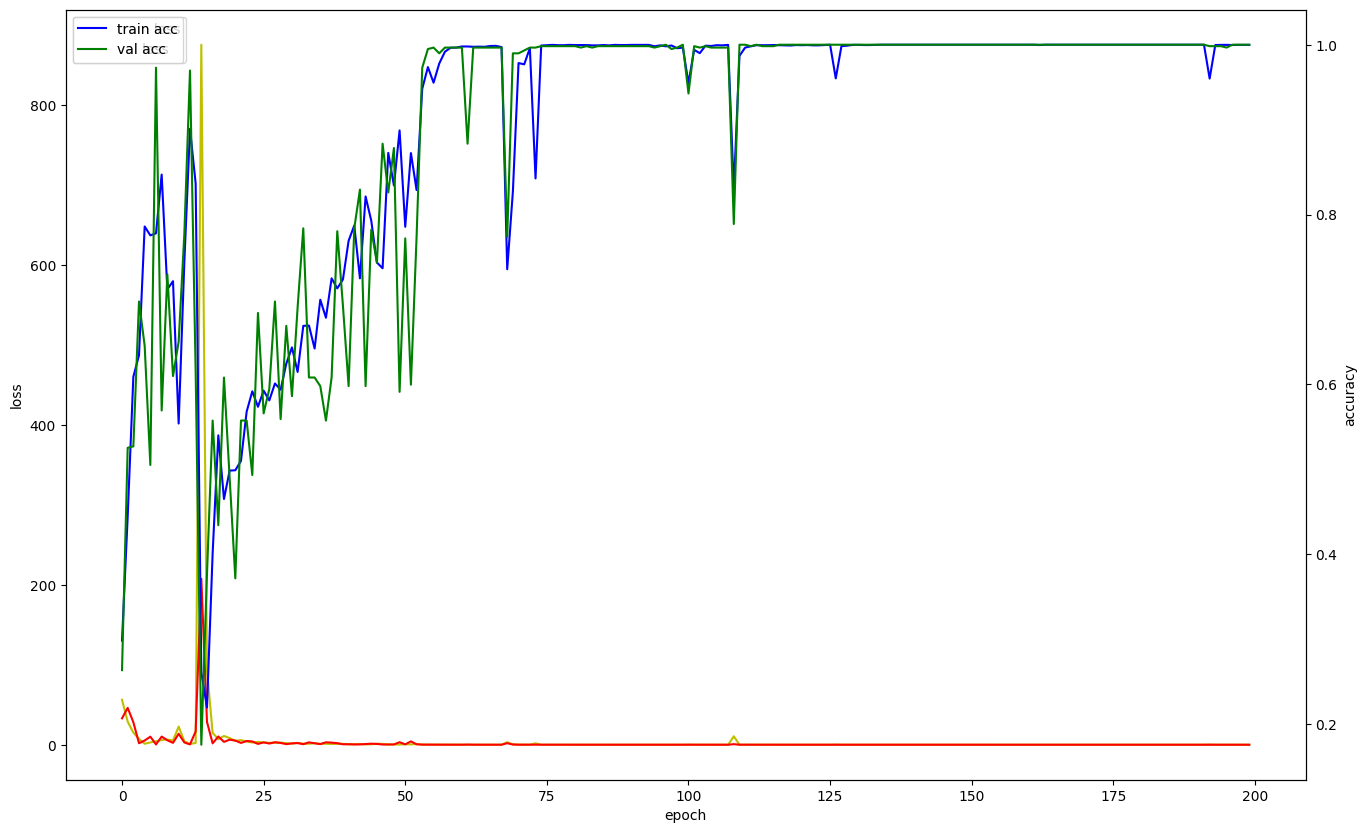

In [75]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [76]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model.keras')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


array([[[485,   0],
        [  0, 107]],

       [[473,   0],
        [  0, 119]],

       [[488,   0],
        [  0, 104]],

       [[458,   0],
        [  0, 134]],

       [[464,   0],
        [  0, 128]]], dtype=int64)